# 测试FOF流程

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm
from sklearn.decomposition import PCA
import statsmodels.api as sm
from time import time

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

framework_path = os.path.join(os.path.abspath(''), '../framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

from light_weight_backtest_manager.backtest import *

from merge_fund_raw_data import MergeFundRawDataAlg
from select_fund_type import SelectFundTypeAlg
from select_fund_condition import SelectFundConditionAlg
from fund_style_identification_alg import *

from import_func import getSvc 
yaml_svc = getSvc('YamlSvc')
constant_svc = getSvc('ConstantSvc')
raw_data_svc = getSvc('LxwWinddbRawDataSvc')
date_svc = getSvc('DateSvc')

date_svc.setTradeDays(raw_data_svc.getTradeDays())
indicator_svc = getSvc('IndicatorSvc')

# from component.asset.asset import Asset

init YamlSvc
init YamlSvc
init LxwWinddbRawDataSvc
init MysqlDbConnectorSvc
init DateSvc
init ConstantSvc
init IndicatorSvc


由于FOF策略需要大量的基金数据，计算非常慢，如果中间出问题会浪费大量时间，因此将回测分为两步

1. 第一次循环确定投资的基金；
2. 第二次计算净值；

In [2]:
# 债券基金筛选条件
bond_filter_condition = {
    'fund_age':3*12,                # 基金年龄 >= n 个月  
    'fund_del': -1e-8, # 基金停牌时间 < 0
    'netasset_total':2e8,    # 基金规模 >= n 元
    'f_prt_stocktotot': -30            # 过去4个季度，股票平均仓位 <= 30
}

# 股票基金筛选条件
stock_filter_condition = {
    'fund_age':3*12,                # 基金年龄 >= n 个月  
    'fund_del': -1e-8, # 基金停牌时间 < 0
    'netasset_total':2e8,    # 基金规模 >= n 元
    'f_prt_stocktotot': 60,           # 过去4个季度，股票平均仓位 >= 60
    'is_indexfund': -0.5   # 不是指数基金
}

In [3]:
merge_fund_raw_data_alg = MergeFundRawDataAlg()
select_fund_type_alg = SelectFundTypeAlg()
select_fund_condition_alg = SelectFundConditionAlg(bond_conditions=bond_filter_condition, stock_conditions=stock_filter_condition)
campisi = Campisi()

In [4]:
class SelectFundsStrategy(Strategy):
    def __init__(self, run_date=[]):
        self._merge_fund_raw_data_alg = merge_fund_raw_data_alg
        self._select_fund_type_alg = select_fund_type_alg
        self._select_fund_condition_alg = select_fund_condition_alg
        self._campisi = campisi

        self._bonds = {}

        self._run_date = run_date

    def run(self, id_date, asset_data):
        if id_date not in self._run_date:
            return None
        # 获取所有可交易的基金
        fund_info = self._merge_fund_raw_data_alg.run(id_date)

        ############################################

        # 债券型基金
        bond_fund_info_type = self._select_fund_type_alg.run(fund_info.copy(), type_='bond')
        
        bond_fund_info_condition = self._select_fund_condition_alg.run(bond_fund_info_type, type_='bond')

        print('{} -- bond_fund_info_condition.shape[0] {}'.format(id_date, bond_fund_info_condition.shape[0]))

        selected_funds = self._campisi.getBestScoreFunds(id_date, bond_fund_info_condition)

        self._bonds[id_date] = selected_funds
        return None


In [5]:
date_range = [datetime(2011,1,1), datetime(2022, 12, 31)]
date_index = date_svc.getIndexWithRange(date_range[0], date_range[1]).index
dummy_asset = pd.DataFrame(1, index=date_index, columns=['asset0'])

In [6]:
date_range = [datetime(2017,1,1), datetime(2022, 7, 1)]
run_date = date_svc.filterDateIndex(date_index, frequency='quarterly')

select_funds_backtest = BacktestManager(
    SelectFundsStrategy(run_date=run_date), 
    dummy_asset, 
    date_range = date_range, 
    frequency = 1, 
    look_back = 252, 
)
select_funds_backtest.run()


  0%|          | 0/1335 [00:00<?, ?it/s]

2017-01-03 00:00:00 -- bond_fund_info_condition.shape[0] 114


c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
  4%|▍         | 54/1335 [02:37<28:40,  1.34s/it]   

2017-04-05 00:00:00 -- bond_fund_info_condition.shape[0] 119


  4%|▍         | 54/1335 [02:47<28:40,  1.34s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
  7%|▋         | 100/1335 [02:55<11:19,  1.82it/s]

2017-07-03 00:00:00 -- bond_fund_info_condition.shape[0] 125


  7%|▋         | 100/1335 [03:09<11:19,  1.82it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 14%|█▎        | 181/1335 [03:19<04:33,  4.22it/s]

2017-10-09 00:00:00 -- bond_fund_info_condition.shape[0] 130


 14%|█▎        | 181/1335 [03:29<04:33,  4.22it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 17%|█▋        | 232/1335 [03:43<04:49,  3.80it/s]

2018-01-02 00:00:00 -- bond_fund_info_condition.shape[0] 119


c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 22%|██▏       | 299/1335 [03:57<03:07,  5.51it/s]

2018-04-02 00:00:00 -- bond_fund_info_condition.shape[0] 109


c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 26%|██▌       | 345/1335 [04:06<02:45,  5.96it/s]

2018-07-02 00:00:00 -- bond_fund_info_condition.shape[0] 106


c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 31%|███       | 415/1335 [04:18<01:58,  7.78it/s]

2018-10-08 00:00:00 -- bond_fund_info_condition.shape[0] 123


 31%|███       | 415/1335 [04:32<01:58,  7.78it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 36%|███▌      | 476/1335 [04:38<02:35,  5.53it/s]

2019-01-02 00:00:00 -- bond_fund_info_condition.shape[0] 151


 36%|███▌      | 476/1335 [04:52<02:35,  5.53it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 41%|████      | 542/1335 [05:21<04:24,  3.00it/s]

2019-04-01 00:00:00 -- bond_fund_info_condition.shape[0] 177


 43%|████▎     | 576/1335 [06:06<07:58,  1.59it/s]

2019-07-01 00:00:00 -- bond_fund_info_condition.shape[0] 214


 43%|████▎     | 576/1335 [06:26<07:58,  1.59it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 49%|████▉     | 660/1335 [07:01<05:36,  2.01it/s]

2019-10-08 00:00:00 -- bond_fund_info_condition.shape[0] 287


 49%|████▉     | 660/1335 [07:18<05:36,  2.01it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 53%|█████▎    | 701/1335 [08:47<12:39,  1.20s/it]

2020-01-02 00:00:00 -- bond_fund_info_condition.shape[0] 413


 53%|█████▎    | 701/1335 [09:02<12:39,  1.20s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 57%|█████▋    | 761/1335 [11:38<17:47,  1.86s/it]

2020-04-01 00:00:00 -- bond_fund_info_condition.shape[0] 472


 57%|█████▋    | 761/1335 [11:49<17:47,  1.86s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 61%|██████▏   | 820/1335 [13:30<14:33,  1.70s/it]

2020-07-01 00:00:00 -- bond_fund_info_condition.shape[0] 506


 61%|██████▏   | 820/1335 [13:42<14:33,  1.70s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 67%|██████▋   | 899/1335 [14:37<07:07,  1.02it/s]

2020-10-09 00:00:00 -- bond_fund_info_condition.shape[0] 522


 67%|██████▋   | 899/1335 [14:54<07:07,  1.02it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 71%|███████   | 944/1335 [15:51<07:21,  1.13s/it]

2021-01-04 00:00:00 -- bond_fund_info_condition.shape[0] 559


 71%|███████   | 944/1335 [16:07<07:21,  1.13s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 75%|███████▌  | 1005/1335 [17:21<06:28,  1.18s/it]

2021-04-01 00:00:00 -- bond_fund_info_condition.shape[0] 610


 75%|███████▌  | 1005/1335 [17:42<06:28,  1.18s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 82%|████████▏ | 1092/1335 [19:13<03:55,  1.03it/s]

2021-07-01 00:00:00 -- bond_fund_info_condition.shape[0] 657


 82%|████████▏ | 1092/1335 [19:26<03:55,  1.03it/s]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 86%|████████▋ | 1152/1335 [21:01<03:05,  1.01s/it]

2021-10-08 00:00:00 -- bond_fund_info_condition.shape[0] 724


 86%|████████▋ | 1152/1335 [21:11<03:05,  1.01s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 89%|████████▉ | 1193/1335 [23:01<03:41,  1.56s/it]

2022-01-04 00:00:00 -- bond_fund_info_condition.shape[0] 806


 89%|████████▉ | 1193/1335 [23:17<03:41,  1.56s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 94%|█████████▎| 1251/1335 [25:01<02:16,  1.62s/it]

2022-04-01 00:00:00 -- bond_fund_info_condition.shape[0] 845


 94%|█████████▎| 1251/1335 [25:14<02:16,  1.62s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
 98%|█████████▊| 1312/1335 [26:33<00:32,  1.40s/it]

2022-07-01 00:00:00 -- bond_fund_info_condition.shape[0] 922


 98%|█████████▊| 1312/1335 [26:47<00:32,  1.40s/it]c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
c:\Users\yuans\Anaconda3\envs\py38\lib\site-packages\quantstats\stats.py:552: RuntimeWarning: divide by zero encountered in double_scalars
  return cagr_ratio / abs(max_dd)
100%|██████████| 1335/1335 [28:42<00:00,  1.29s/it]


In [7]:
for k,v in select_funds_backtest._strategy._bonds.items():
    print(k, sorted(v))

2017-01-03 00:00:00 ['000254.OF', '000317.OF', '000429.OF', '050027.OF', '163210.SZ', '163910.OF', '166902.SZ', '166904.SZ', '519152.OF', '650001.OF']
2017-04-05 00:00:00 ['000286.OF', '000317.OF', '000429.OF', '050027.OF', '163210.SZ', '163826.OF', '163910.OF', '166902.SZ', '166904.SZ', '519152.OF']
2017-07-03 00:00:00 ['000174.OF', '000286.OF', '000317.OF', '000429.OF', '000632!1.OF', '050027.OF', '166902.SZ', '166904.SZ', '519152.OF', '519669.OF']
2017-10-09 00:00:00 ['000286.OF', '000317.OF', '000387.OF', '000429.OF', '000769.OF', '110007.OF', '163826.OF', '163910.OF', '166902.SZ', '519152.OF']
2018-01-02 00:00:00 ['000286.OF', '000346.OF', '000429.OF', '000744.OF', '000769.OF', '040040.OF', '166902.SZ', '270044.OF', '519152.OF', '519669.OF']
2018-04-02 00:00:00 ['000286.OF', '000346.OF', '000419.OF', '000429.OF', '000744.OF', '040040.OF', '166902.SZ', '270044.OF', '519152.OF', '519669.OF']
2018-07-02 00:00:00 ['000346.OF', '000419.OF', '000429.OF', '000744.OF', '162715.SZ', '16690

In [8]:
# make data
fund_data = pd.DataFrame(index=date_index)
for fund in set(sum(select_funds_backtest._strategy._bonds.values(), [])):
    fund_data[fund] = select_funds_backtest._strategy._campisi._fund_asset[fund].getRawNavData()


In [9]:
class TestFofStrategy(Strategy):
    def __init__(self, selected_fund):
        self._selected_fund = selected_fund

    def run(self, id_date, asset_data):
        # control the frequency
        if id_date not in self._selected_fund:
            return None

        weights = pd.Series(0, index=asset_data.columns)
        weights.loc[self._selected_fund[id_date]] = 1 / len(self._selected_fund[id_date])

        return weights

In [10]:
date_range = [datetime(2017,1,1), datetime(2022, 7, 1)]
fof_backtest = BacktestManager(
    TestFofStrategy(selected_fund=select_funds_backtest._strategy._bonds), 
    fund_data, 
    date_range = date_range, 
    frequency = 1, 
    look_back = 252, 
)
fof_backtest.run()

100%|██████████| 1335/1335 [00:05<00:00, 245.62it/s]


<AxesSubplot:>

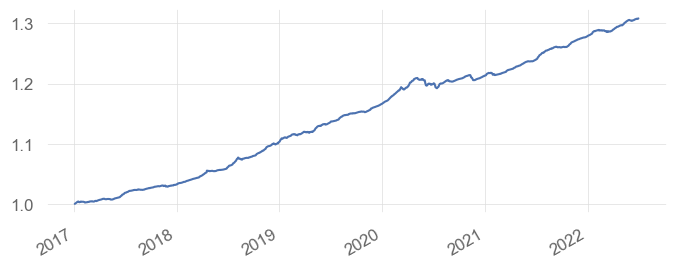

In [11]:
fof_backtest.getHistoricalValue(scale=True).plot(figsize=(8,3), grid=True)

In [34]:
metrics = pd.Series(dtype=float)
values = fof_backtest.getHistoricalValue(scale=True)

# 分年度收益率
for year in values.index.year.unique():
    tmp = values.loc[str(year)]
    metrics[str(year)] = tmp.iloc[-1] / tmp.iloc[0] - 1

metrics['annualized_return'] = (values.iloc[-1]/values.iloc[0]) ** (constant_svc.DAY_OF_YEAR/values.shape[0]) - 1
metrics['annualized_volatility'] = values.pct_change().std() * constant_svc.DAY_OF_YEAR**0.5
metrics['max_drawback'] = max(max(values.iloc[:i])-min(values.iloc[i:]) for i in range(1, values.shape[0]))
metrics['sharpe'] = indicator_svc.getSharpe(values.pct_change())
metrics['calmar'] = indicator_svc.getCalmar(values.pct_change())

metrics


2017                     0.031979
2018                     0.067220
2019                     0.056710
2020                     0.039898
2021                     0.053888
2022                     0.022282
annualized_return        0.052050
annualized_volatility    0.006410
max_drawback             0.017022
sharpe                   5.598699
calmar                   3.563001
dtype: float64